## Importing all libraries

In [56]:
import numpy as np 
import matplotlib.pyplot as plt  
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,KFold,RandomizedSearchCV, cross_val_score
from scipy.stats import pearsonr
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings('ignore')

In [57]:
# read the file
df2 = pd.read_csv('initiation_combined.csv')
df = df2.drop(['gene_name'],axis=1)
df['folding_energy_70'] = pd.to_numeric(df['folding_energy_70'], errors='coerce')
df['folding_energy_70'] = df['folding_energy_70'].fillna(0)

## Filtering the data using 5th and 95th percentiles

In [58]:
# Calculate the 5th and 95th percentiles
lower_percentile = df['romano_initiation_rate'].quantile(0.05)
upper_percentile = df['romano_initiation_rate'].quantile(0.95)

# Filter the DataFrame
df = df[(df['romano_initiation_rate'] >= lower_percentile) & (df['romano_initiation_rate'] <= upper_percentile)]
df

,romano_initiation_rate,gene_length,folding_energy_70,folding_energy_80,length_of_5prime_utr,kozak_score,N1,N4,in_frame AUG
0,0.07395,797,-8.2,-6.5,23,5,4,1,0
1,0.12524,102,-11.3,-8.6,61,4,4,3,0
2,0.16670,421,-8.0,-11.2,51,3,1,3,0
3,0.08171,566,-4.7,-4.7,16,3,4,1,0
5,0.04504,692,-10.0,-7.4,91,4,4,2,0
...,...,...,...,...,...,...,...,...,...
1021,0.14914,445,-12.2,-8.9,43,3,3,1,0
1022,0.08978,582,-6.9,-11.7,49,3,2,1,0
1023,0.09928,498,-5.6,-11.8,182,5,2,1,0
1024,0.03961,258,-10.8,-10.0,43,3,4,2,0


In [59]:
# print the min and max after filtering
print(df['romano_initiation_rate'].min())
print(df['romano_initiation_rate'].max())

0.0275
0.23006


In [60]:
corr = df.corr()
print(corr.romano_initiation_rate.sort_values(ascending=False))

romano_initiation_rate    1.000000
folding_energy_80         0.336601
folding_energy_70         0.298337
kozak_score               0.272276
in_frame AUG             -0.058506
length_of_5prime_utr     -0.109026
N4                       -0.151758
N1                       -0.155246
gene_length              -0.472826
Name: romano_initiation_rate, dtype: float64


## Assigning the target variable and train-test split 

In [61]:
X = df.drop('romano_initiation_rate',axis=1)
y = df['romano_initiation_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Hyperparamter Tuning

In [62]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 30)]
# Number of features to consider at every split
max_features = ['sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80,10)]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':[ 'absolute_error','squared_error']}

In [63]:
rf=RandomForestRegressor()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=30,
                               cv=5,verbose=2,n_jobs=-1,random_state=42)

In [64]:
# fit the randomized model
rf_randomcv.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'criterion': ['absolute_error',
                                                      'squared_error'],
                                        'max_depth': [10, 17, 25, 33, 41, 48,
                                                      56, 64, 72, 80],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [1, 2, 4],
                                        'n_estimators': [100, 113, 127, 141,
                                                         155, 168, 182, 196,
                                                         210, 224, 237, 251,
                                                         265, 279, 293, 306,
                                                         320, 334, 348, 362,
                                                         375, 389, 403, 417,
                                                         431, 444, 458, 472,
                                                         486, 500]},
                   random_state=42, verbose=2)

In [65]:
model = rf_randomcv.best_estimator_

In [68]:
data_train = pd.DataFrame(columns=['Pearson R', 'MSE'])
data_test = pd.DataFrame(columns=['Pearson R', 'MSE'])

# Cross validation method defined
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X_train):
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]

    # Use a different variable name for the model inside the loop
    cv_model = model.fit(X1_train, y1_train)

    y_train_pred = cv_model.predict(X1_train)
    r_train, _ = pearsonr(y1_train, y_train_pred)
    mse_train = mean_squared_error(y1_train, y_train_pred)

    y_test_pred = cv_model.predict(X1_test)
    r_test, _ = pearsonr(y1_test, y_test_pred)
    mse_test = mean_squared_error(y1_test, y_test_pred)
    
    data_train = pd.concat([data_train, pd.DataFrame({'Pearson R': r_train, 'MSE': mse_train} ,
                                                     index=[0])], ignore_index=True)
    data_test = pd.concat([data_test, pd.DataFrame({'Pearson R': r_train, 'MSE': mse_train} ,
                                                     index=[0])], ignore_index=True)
print('Train set\n',data_train), print('Test set\n',data_test)

Train set
    Pearson R       MSE
0   0.939757  0.000357
1   0.938744  0.000365
2   0.940746  0.000354
3   0.937226  0.000372
4   0.942822  0.000340
Test set
    Pearson R       MSE
0   0.939757  0.000357
1   0.938744  0.000365
2   0.940746  0.000354
3   0.937226  0.000372
4   0.942822  0.000340


(None, None)

In [67]:
y_train_pred = model.predict(X_train)
r_train, _ = pearsonr(y_train, y_train_pred)
print(r_train)
y_test_pred = model.predict(X_test)
r_test, _ = pearsonr(y_test, y_test_pred)
print(r_test)

0.8403931897210373
0.8198176386851905
[CV] END criterion=squared_error, max_depth=64, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=444; total time=   1.6s
[CV] END criterion=squared_error, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=196; total time=   0.6s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=182; total time=   0.0s
[CV] END criterion=squared_error, max_depth=48, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=486; total time=   1.9s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=375; total time=   1.4s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=113; total time=   0.0s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_s

[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=182; total time=   0.0s
[CV] END criterion=squared_error, max_depth=48, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=486; total time=   1.6s
[CV] END criterion=absolute_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=444; total time=   2.4s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=431; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=431; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=237; total time=   2.4s
[CV] END criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=403; t

[CV] END criterion=squared_error, max_depth=41, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=113; total time=   0.4s
[CV] END criterion=absolute_error, max_depth=41, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=168; total time=   2.4s
[CV] END criterion=absolute_error, max_depth=72, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=127; total time=   1.9s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=375; total time=   1.3s
[CV] END criterion=squared_error, max_depth=48, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=113; total time=   0.5s
[CV] END criterion=squared_error, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=196; total time=   0.6s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=431; to

[CV] END criterion=squared_error, max_depth=48, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=155; total time=   0.6s
[CV] END criterion=absolute_error, max_depth=56, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=389; total time=   4.8s
[CV] END criterion=squared_error, max_depth=48, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=486; total time=   1.6s
[CV] END criterion=absolute_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=444; total time=   3.0s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=431; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=80, max_features=log2, min_samples_leaf=1, min_samples_split=1, n_estimators=431; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=237; 

[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=375; total time=   1.4s
[CV] END criterion=squared_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=362; total time=   0.0s
[CV] END criterion=squared_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=362; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=56, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=141; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=56, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=141; total time=   0.0s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=113; total time=   0.0s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=113; to

[CV] END criterion=absolute_error, max_depth=72, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=127; total time=   1.9s
[CV] END criterion=absolute_error, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=375; total time=   3.3s
[CV] END criterion=squared_error, max_depth=64, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=444; total time=   1.5s
[CV] END criterion=squared_error, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=444; total time=   1.6s
[CV] END criterion=absolute_error, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=320; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=41, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=168; total time=   2.3s
[CV] END criterion=squared_error, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=403; 

[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=1, n_estimators=431; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=41, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=168; total time=   2.6s
[CV] END criterion=squared_error, max_depth=48, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=155; total time=   0.6s
[CV] END criterion=absolute_error, max_depth=56, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=389; total time=   4.8s
[CV] END criterion=squared_error, max_depth=48, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=486; total time=   1.6s
[CV] END criterion=absolute_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=444; total time=   2.9s
[CV] END criterion=absolute_error, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=320; 

[CV] END criterion=absolute_error, max_depth=17, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=320; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=72, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=224; total time=   2.1s
[CV] END criterion=squared_error, max_depth=41, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=375; total time=   1.3s
[CV] END criterion=squared_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=362; total time=   0.0s
[CV] END criterion=squared_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=362; total time=   0.0s
[CV] END criterion=squared_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=362; total time=   0.0s
[CV] END criterion=squared_error, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=1, n_estimators=362; to

## Model Prediction

In [25]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

## PearsonR for train and test data

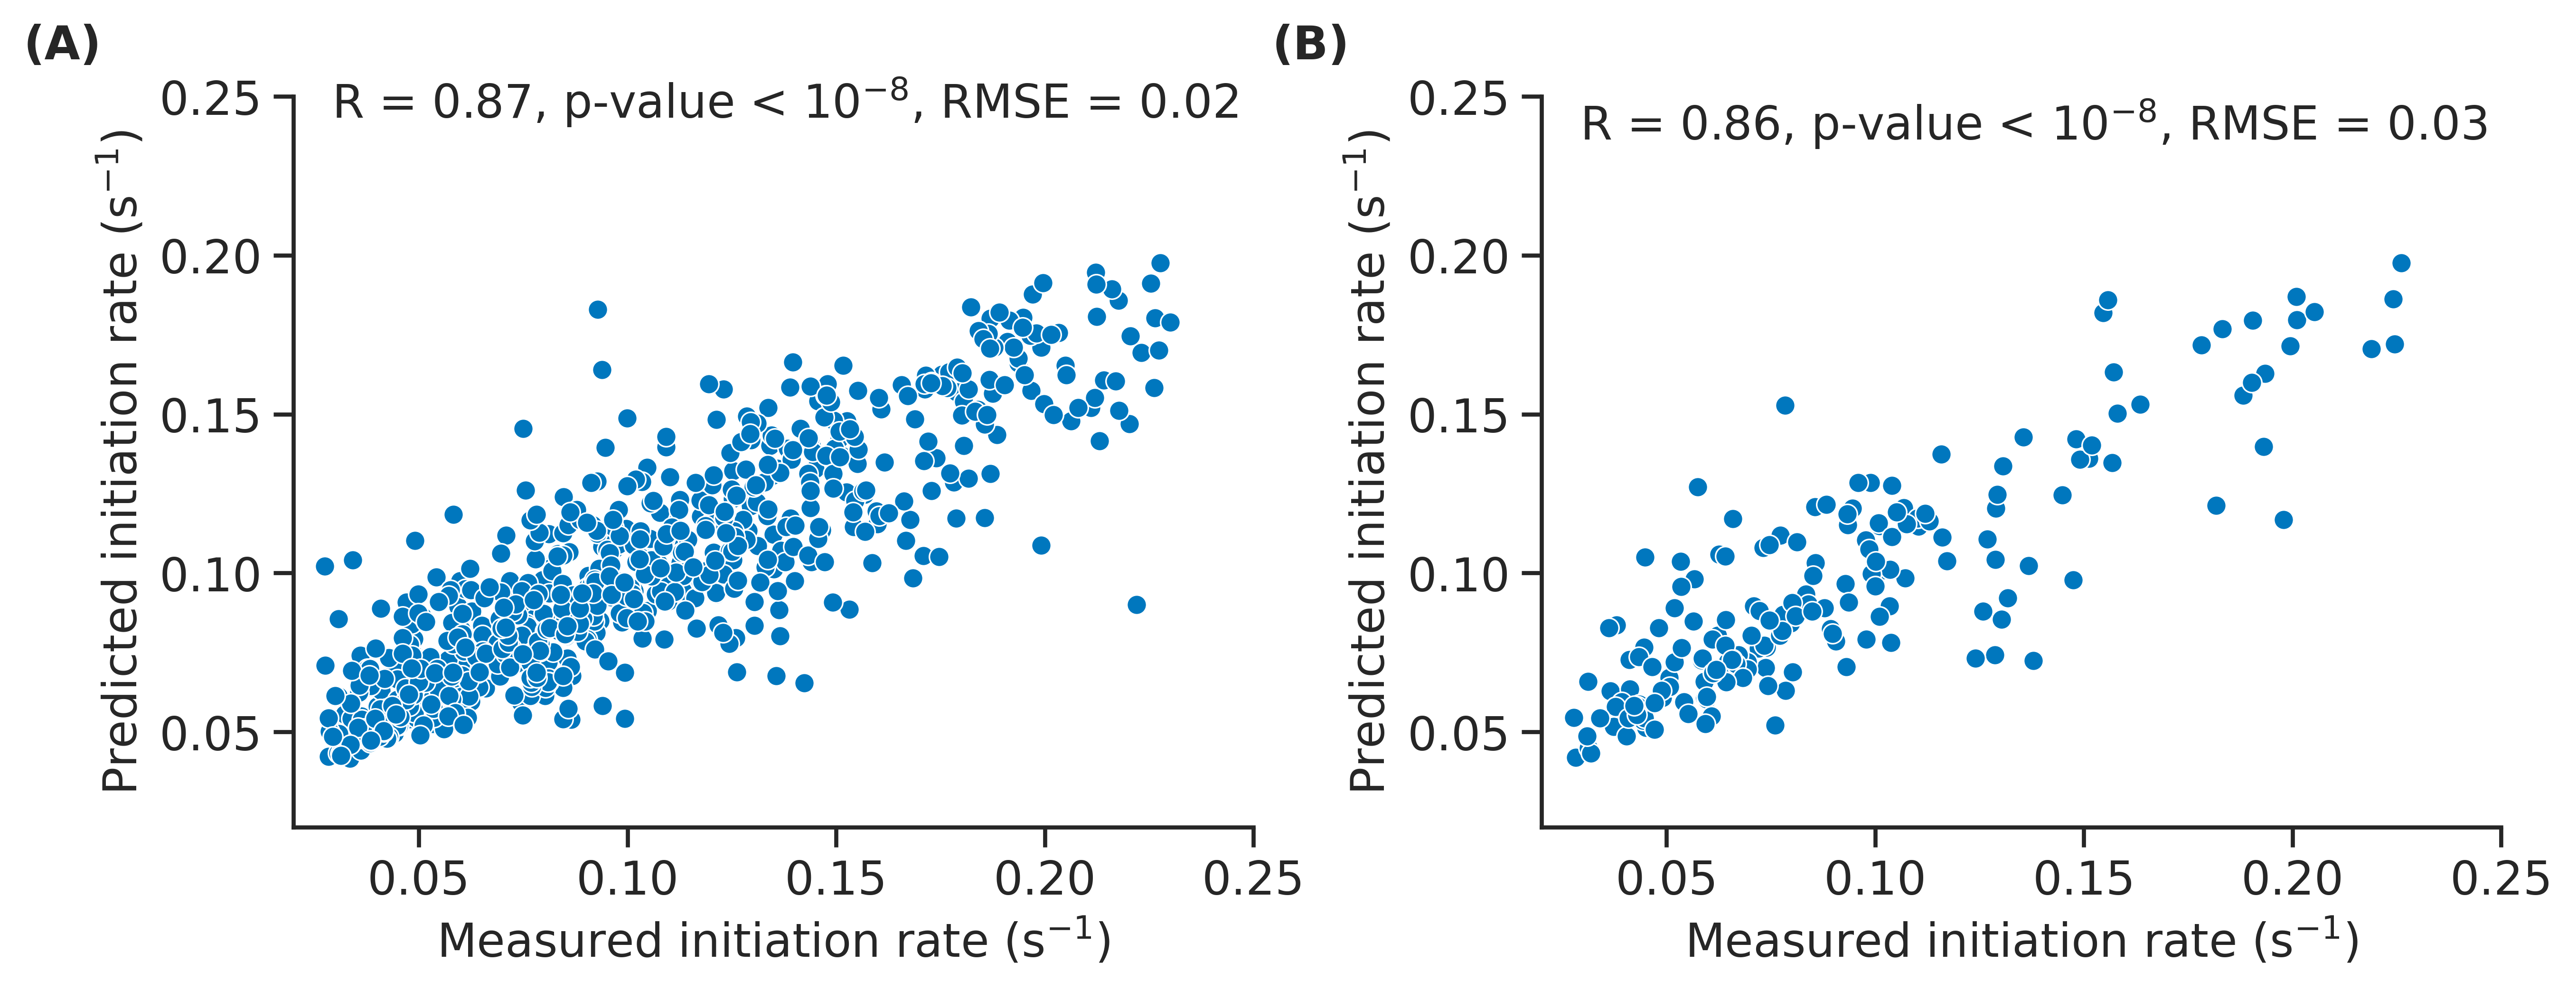

In [381]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), dpi=500)

# Training set
sns.scatterplot(x=y_train, y=y_train_pred, ax=ax1, color='#0077be')
ax1.set_xlabel(r"Measured initiation rate ($\mathrm{s^{-1}}$)", fontsize=14)
ax1.set_ylabel(r"Predicted initiation rate ($\mathrm{s^{-1}}$)", fontsize=14)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', labelsize=14)
r_train, p_train = pearsonr(x=y_train, y=y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
i = 0
p_train_exp = f"{p_train:.0e}"
if p_train < 1e-8:
    p_train_exp = 'p-value < 10$^{-8}$'
else:
    p_train_exp_parts = p_train_exp.split('e')
    p_train_exp = f"{p_train_exp_parts[0]} × 10$^{{{p_train_exp_parts[1]}}}$"
ax1.text(0.04, 1.03, f"R = {r_train:.2f}, {p_train_exp}, RMSE = {rmse_train:.2f}", transform=ax1.transAxes, fontsize=14, verticalalignment='top')
ax1.text(-0.2, 1.1, f'({chr(65 + i)})', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# Test set
sns.scatterplot(x=y_test, y=y_test_pred, ax=ax2, color='#0077be')
ax2.set_xlabel(r"Measured initiation rate ($\mathrm{s^{-1}}$)", fontsize=14)
ax2.set_ylabel(r"Predicted initiation rate ($\mathrm{s^{-1}}$)", fontsize=14)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', labelsize=14)
r_test, p_test = pearsonr(x=y_test, y=y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
i = 1
p_test_exp = f"{p_test:.0e}"
if p_test < 1e-8:
    p_test_exp = 'p-value < 10$^{-8}$'
else:
    p_test_exp_parts = p_test_exp.split('e')
    p_test_exp = f"{p_test_exp_parts[0]} × 10$^{{{p_test_exp_parts[1]}}}$"
ax2.text(0.04, 1, f"R = {r_test:.2f}, {p_test_exp}, RMSE = {rmse_test:.2f}", transform=ax2.transAxes, fontsize=14, verticalalignment='top')
ax2.text(-0.2, 1.1, f'({chr(65 + i)})', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

ax1.set_ylim(0.02, 0.25)
ax1.set_xlim(0.02, 0.25)
ax2.set_ylim(0.02, 0.25)
ax2.set_xlim(0.02, 0.25)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
plt.show()

## Residual plot for train and test combined

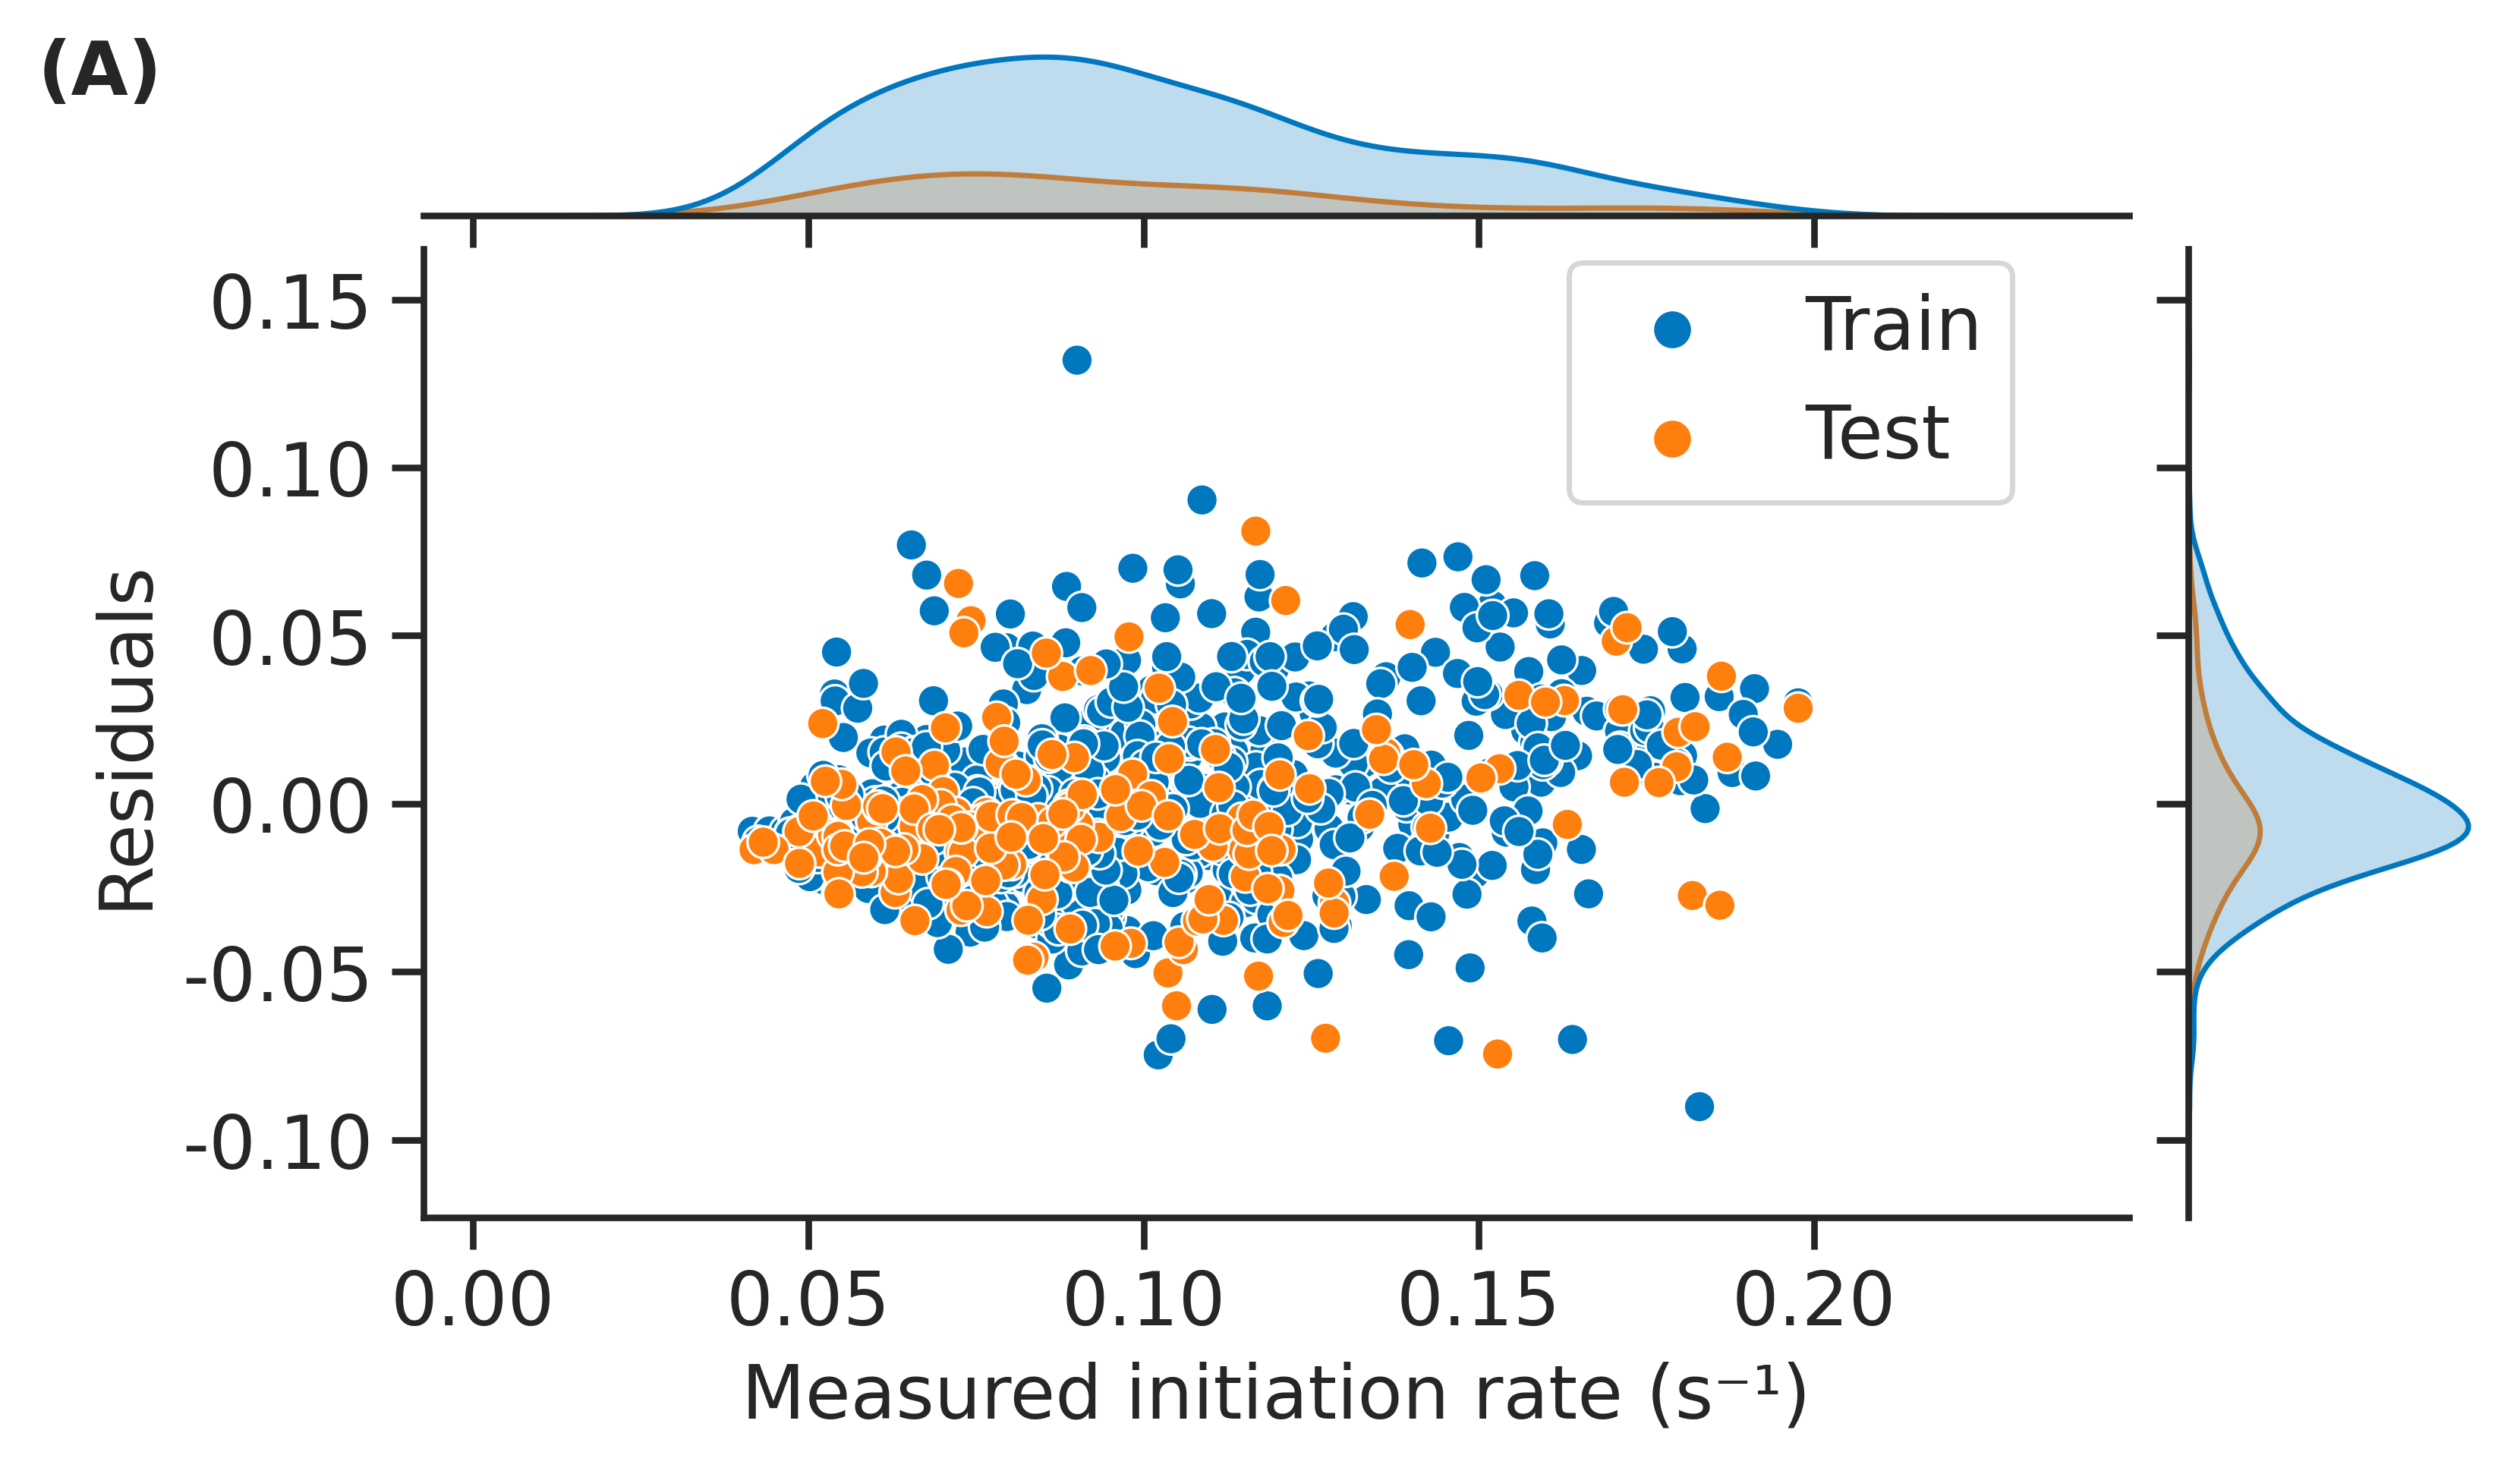

In [366]:
# Combine train and test data
residuals_train = y_train - y_train_pred

plot_data_train = pd.DataFrame()
plot_data_train['Residuals'] = residuals_train.ravel()
plot_data_train['Translation initiation rate'] = y_train_pred.ravel()
plot_data_train['Dataset'] = 'Train'

residuals_test = y_test - y_test_pred
plot_data_test = pd.DataFrame()
plot_data_test['Residuals'] = residuals_test.ravel()
plot_data_test['Translation initiation rate'] = y_test_pred.ravel()
plot_data_test['Dataset'] = 'Test'

plot_data_combined = pd.concat([plot_data_train, plot_data_test])

# Plotting
sns.set(style="ticks", font_scale=5, rc={"figure.dpi": 500})
g = sns.jointplot(x='Translation initiation rate', y='Residuals', data=plot_data_combined, hue='Dataset', palette={'Train': '#0077be', 'Test': '#ff7f0e'},  height=6)
g.fig.set_size_inches(7, 4)
g.ax_joint.set_ylabel('Residuals', fontsize=14)
g.ax_joint.set_xlabel('Measured initiation rate (s⁻¹)', fontsize=14)
g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Ensure equally distributed tick labels on x-axis
g.ax_joint.set_xticklabels([f'{x:.2f}' for x in g.ax_joint.get_xticks()], fontsize=14)  # Set tick labels to 2 decimal points
g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Ensure equally distributed tick labels on y-axis
g.ax_joint.set_yticklabels([f'{y:.2f}' for y in g.ax_joint.get_yticks()], fontsize=14)  # Set tick labels to 2 decimal points
g.ax_joint.legend(bbox_to_anchor=(0.65, 0.7), fontsize=14, title_fontsize=14)

g.fig.text(-0.02, 0.85, '(A)', fontsize=14, fontweight='bold', transform=g.fig.transFigure)

plt.show()


## Save Model as Pickle Object

In [361]:
import pickle
pickle.dump(model, open('tir_rf_model.pkl', 'wb'))

In [ ]:
results_train = pd.DataFrame({'True Values': y_train, 'Predicted Values': y_train_pred})
results_train.to_csv('RF_train_set.csv', index= False)
results_test = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_test_pred})
data = pd.concat([results_train, results_test], axis=0)

In [368]:
df2

,gene_name,romano_initiation_rate,gene_length,folding_energy_70,folding_energy_80,length_of_5prime_utr,kozak_score,N1,N4,in_frame AUG
0,YOL076W,0.07395,797,-8.2,-6.5,23,5,4,1,0
1,YGL204C,0.12524,102,-11.3,-8.6,61,4,4,3,0
2,YMR204C,0.16670,421,-8,-11.2,51,3,1,3,0
3,YOR386W,0.08171,566,-4.7,-4.7,16,3,4,1,0
4,YDL240W,0.02254,1018,-10.9,-10.4,174,4,2,3,0
...,...,...,...,...,...,...,...,...,...,...
1021,YMR268C,0.14914,445,-12.2,-8.9,43,3,3,1,0
1022,YML127W,0.08978,582,-6.9,-11.7,49,3,2,1,0
1023,YOL137W,0.09928,498,-5.6,-11.8,182,5,2,1,0
1024,YOR060C,0.03961,258,-10.8,-10.0,43,3,4,2,0


In [369]:
gene_name_new = []

for i in range(len(data)):
    if data['True Values'][i] in df2['romano_initiation_rate'].values:
        gene_name_new.append(df2.loc[df2['romano_initiation_rate'] == data['True Values'][i], 'gene_name'].iloc[0])
    else:
        gene_name_new.append(None)

data['gene_name'] = gene_name_new

In [370]:
data[data['Predicted Values'] == data['Predicted Values'].min()]

,True Values,Predicted Values,gene_name
211,0.03346,0.041636,YLR001C


In [371]:
data[data['Predicted Values'] == data['Predicted Values'].max()]

,True Values,Predicted Values,gene_name
867,0.22604,0.197631,YER011W


## Comparison with other datasets

In [376]:
df3 = pd.read_csv('data_final - data_final.csv')
df3 = df3.drop(['s_no.'], axis=1)
df3

,gene,romano_initiation_rate,gene_length,weinberg_initiation_rate,dou_duck_initiation_rate,metabolic_cost,cai,mRNA_half_life,protein_copy_number,protein_per_mRNA,...,7,8,9,10,11,12,GC,frac GC,in_frame AUG,out_frame AUG
0,YAL008W,0.15050,199,0.276835,NaN,28.721106,0.115,27.5,1993.64239,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,YBR255W,0.03368,695,NaN,NaN,25.125899,0.111,8.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,YGR164W,0.27984,112,NaN,NaN,28.750000,0.119,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YGR131W,0.22936,175,NaN,NaN,28.242857,0.102,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YNL003C,0.09958,285,NaN,NaN,26.849123,0.115,4.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6664,YPR117W,0.02378,2490,NaN,NaN,27.781526,0.122,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6665,YHR086W,0.05300,524,NaN,NaN,24.621183,0.124,5.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6666,YBR015C,0.14430,598,0.067900,0.063924,27.790134,0.170,4.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6667,YPL013C,0.26796,122,0.117000,NaN,25.950820,0.087,4.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [377]:
df3['weinberg_initiation_rate']

0       0.276835
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
6664         NaN
6665         NaN
6666    0.067900
6667    0.117000
6668         NaN
Name: weinberg_initiation_rate, Length: 6669, dtype: float64

In [378]:
weinberg_initiation_rate = []

for gene_name in data['gene_name']:
    if gene_name in df3['gene'].values:
        weinberg_initiation_rate.append(df3.loc[df3['gene'] == gene_name, 'weinberg_initiation_rate'].iloc[0])
    else:
        weinberg_initiation_rate.append(None)

df4 = data.copy() 
df4['weinberg_initiation_rate'] = weinberg_initiation_rate[:len(data)]  
df4 = df4[df4['weinberg_initiation_rate'] <= 0.25]
df4 = df4.dropna()
df4

,True Values,Predicted Values,gene_name,weinberg_initiation_rate
0,0.08199,0.101875,YPL210C,0.068400
5,0.14791,0.159536,YLR216C,0.120085
6,0.08334,0.106003,YPR131C,0.115000
8,0.11252,0.123111,YLR021W,0.067700
12,0.13420,0.140157,YBR234C,0.096600
...,...,...,...,...
893,0.19943,0.171457,YNL160W,0.191000
894,0.10401,0.127583,YGR161C,0.179528
903,0.15192,0.140296,YGR086C,0.108000
904,0.12877,0.104313,YLR208W,0.232000


In [379]:
dou_duck_initiation_rate = []

for gene_name in data['gene_name']:
    if gene_name in df3['gene'].values:
        dou_duck_initiation_rate.append(df3.loc[df3['gene'] == gene_name, 'dou_duck_initiation_rate'].iloc[0])
    else:
        dou_duck_initiation_rate.append(None)
df5 = data.copy() 
df5['dou_duck_initiation_rate'] = dou_duck_initiation_rate[:len(data)]  
df5 = df5.dropna()
df5

,True Values,Predicted Values,gene_name,dou_duck_initiation_rate
3,0.15076,0.142364,YNL134C,0.191166
5,0.14791,0.159536,YLR216C,0.126403
12,0.13420,0.140157,YBR234C,0.102657
19,0.18859,0.143532,YBL064C,0.096685
24,0.11053,0.117796,YOR271C,0.069398
...,...,...,...,...
884,0.13176,0.092125,YGR264C,0.067551
903,0.15192,0.140296,YGR086C,0.097519
904,0.12877,0.104313,YLR208W,0.174736
909,0.10518,0.119113,YNR061C,0.106611


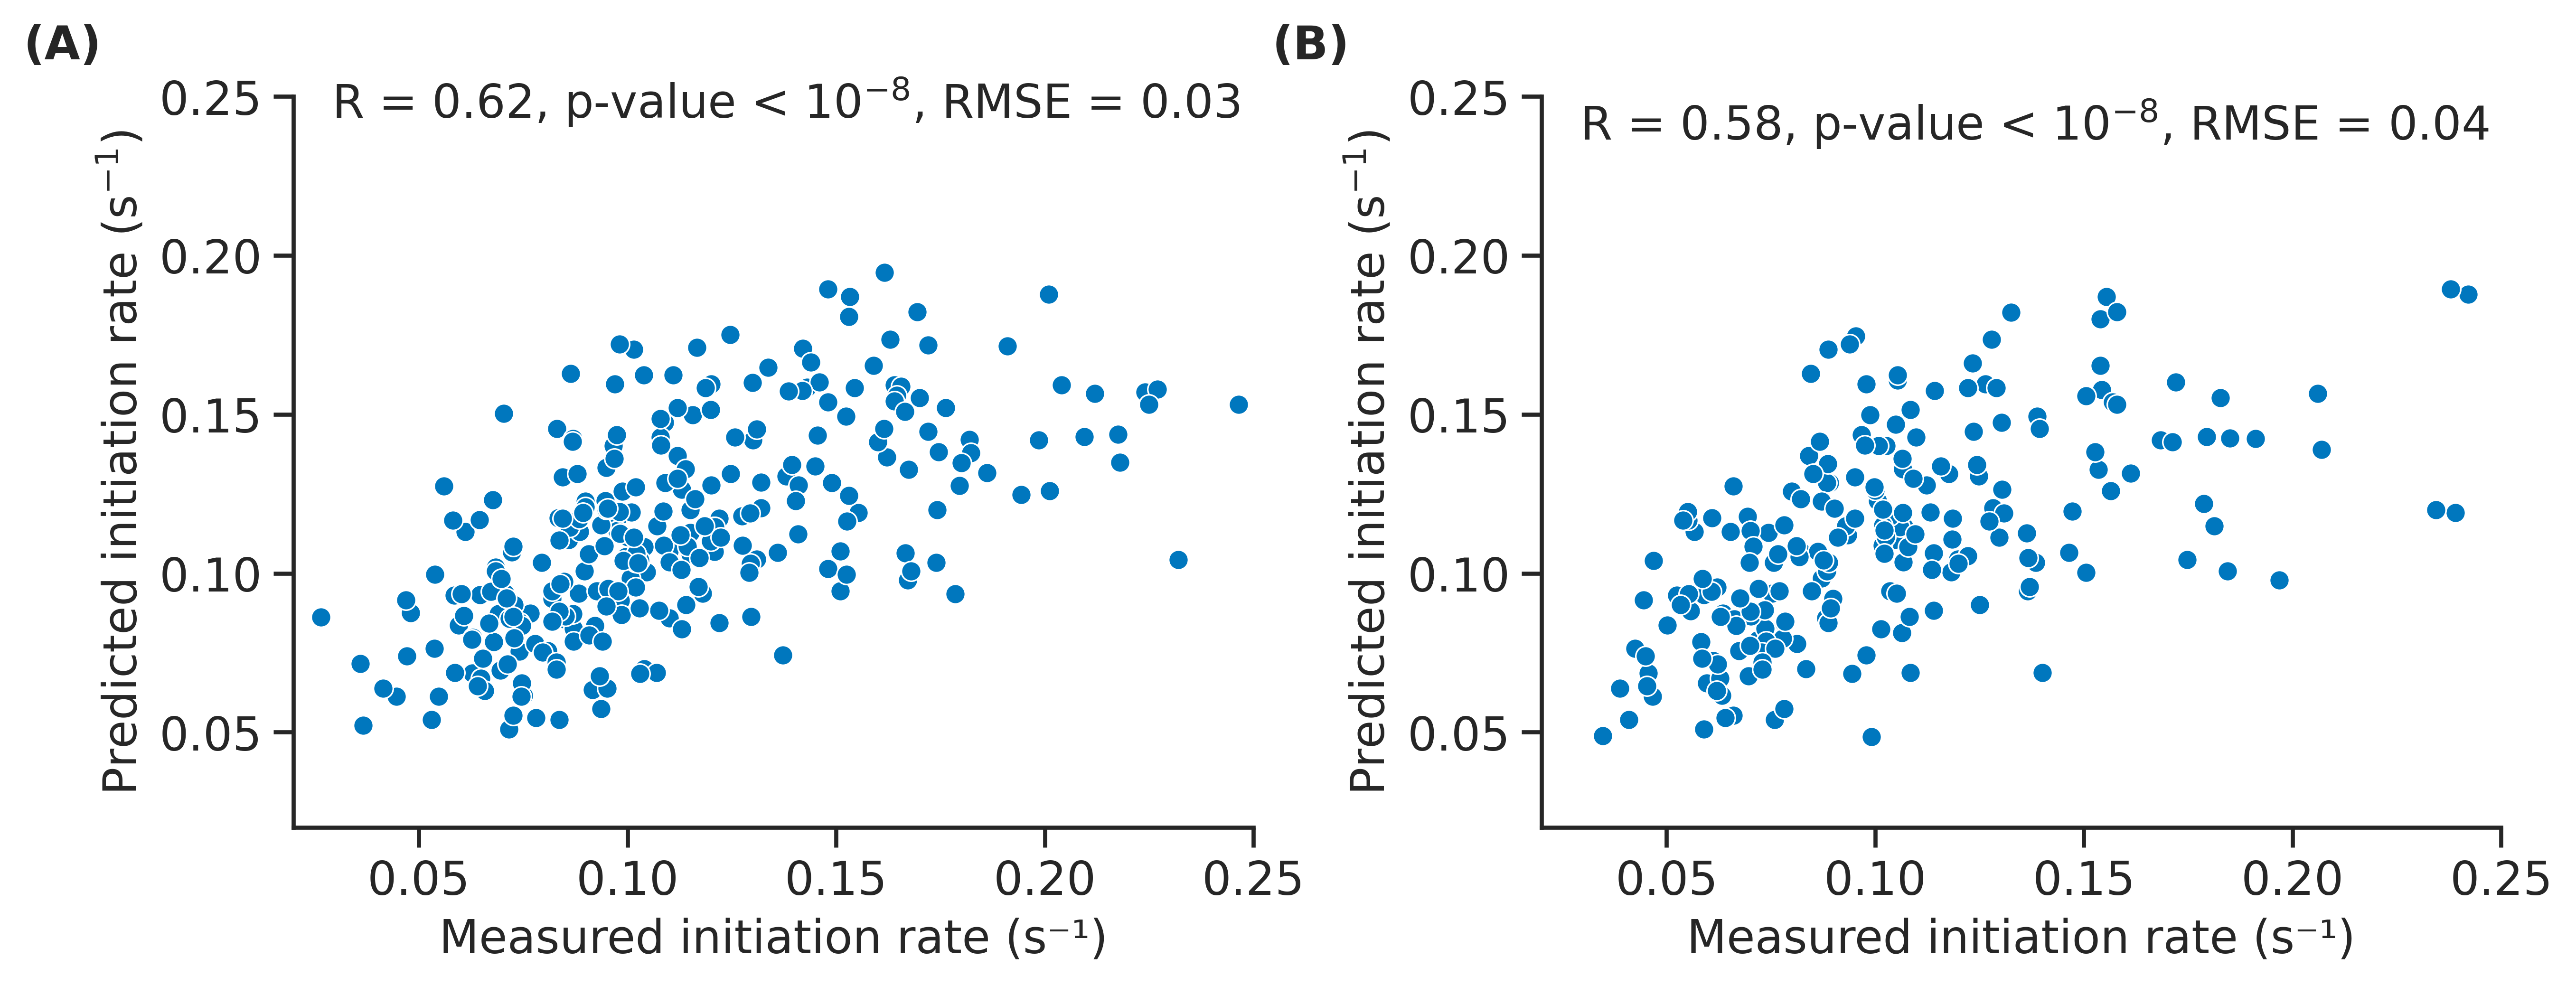

In [382]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), dpi=500)

# Scatter plot for the first subplot
sns.scatterplot(x=df4['weinberg_initiation_rate'], y=df4['Predicted Values'], ax=ax1, color='#0077be') 
ax1.set_xlabel(r"Measured initiation rate (s⁻¹)", fontsize=14)
ax1.set_ylabel(r"Predicted initiation rate ($\mathrm{s^{-1}}$)", fontsize=14)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', labelsize=14)
r1, p1 = pearsonr(df4['Predicted Values'], df4['weinberg_initiation_rate'])
mse1 = mean_squared_error(df4['weinberg_initiation_rate'], df4['Predicted Values'])
rmse1 = np.sqrt(mse1)
i = 0
p1_exp = f"{p1:.0e}"
if p1 < 1e-8:
    p1_exp = 'p-value < 10$^{-8}$'
else:
    p1_exp_parts = p1_exp.split('e')
    p1_exp = f"{p1_exp_parts[0]} × 10$^{{{p1_exp_parts[1]}}}$"
ax1.text(0.04, 1.03, f"R = {r1:.2f}, {p1_exp}, RMSE = {rmse1:.2f}", transform=ax1.transAxes, fontsize=14, verticalalignment='top')
ax1.text(-0.2, 1.1, f'({chr(65 + i)})', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# Scatter plot for the second subplot
sns.scatterplot(x=df5['dou_duck_initiation_rate'], y=df5['Predicted Values'], ax=ax2, color='#0077be') 
ax2.set_xlabel(r"Measured initiation rate (s⁻¹)", fontsize=14)
ax2.set_ylabel(r"Predicted initiation rate ($\mathrm{s^{-1}}$)", fontsize=14)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', labelsize=14)
r2, p2 = pearsonr(df5['Predicted Values'], df5['dou_duck_initiation_rate']) 
mse2 = mean_squared_error(df5['dou_duck_initiation_rate'], df5['Predicted Values'])
rmse2 = np.sqrt(mse2)
i = 1
p2_exp = f"{p2:.0e}"
if p2 < 1e-8:
    p2_exp = 'p-value < 10$^{-8}$'
else:
    p2_exp_parts = p2_exp.split('e')
    p2_exp = f"{p2_exp_parts[0]} × 10$^{{{p2_exp_parts[1]}}}$"
ax2.text(0.04, 1, f"R = {r2:.2f}, {p2_exp}, RMSE = {rmse2:.2f}", transform=ax2.transAxes, fontsize=14, verticalalignment='top')
ax2.text(-0.2, 1.1, f'({chr(65 + i)})', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

ax1.set_ylim(0.02, 0.25)
ax1.set_xlim(0.02, 0.25)
ax2.set_ylim(0.02, 0.25)
ax2.set_xlim(0.02, 0.25)

plt.subplots_adjust(wspace=0.3)
plt.show()